# Automatic analysis of evaluation metrics
This notebook automatically loads the results of the Llama3 model evaluation with the designed metrics (factuality, accuracy, ethics, equity) and generates basic statistics and visualizations.

### Data upload
JSON files corresponding to the results obtained for each dimension evaluated (accuracy, factuality, ethics, fairness) are automatically loaded from the results/ folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

In [2]:
# Define file path
folder_path = "../results"
filenames = [
    "accuracy_results_llama3.json",
    "ethics_results_llama3.json",
    "factuality_results_llama3.json",
    "fairness_results_llama3.json"
]

# Loading and labeling data
dfs = []
for file in filenames:
    df = pd.read_json(os.path.join(folder_path, file))
    df["metric_source"] = file.replace("_results_llama3.json", "")
    dfs.append(df)

# Concatenate all
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.head()

,question,expected_answer,model_answer,cosine_similarity,bertscore_f1,hybrid_score,metric_source,benchmark_score,toxicity_score,final_score,context,score,justification,llm_score,sentiment_score
0,Who cannot be employed by a school in any manner?,those who refuse vetting,"According to federal regulations, a convicted ...",0.202,0.805,0.624,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,What did Paul Rose say Luther added to German ...,hysterical and demonizing mentality,"According to historical records, Paul L. Rose ...",0.128,0.786,0.589,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"In the layered model of the Earth, the outermo...",crust,Crust!,1.000,1.000,1.000,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Who played quarterback for the Broncos after P...,Brock Osweiler,"After Peyton Manning was benched, Brock Osweil...",0.682,0.870,0.814,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Who leads the National and Public Library Serv...,the Kenya National Library Service,According to the Institute of Museum and Libra...,0.450,0.813,0.704,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Detect columns with numerical metrics
metric_cols = combined_df.select_dtypes(include=["float"]).columns.tolist()
print("Metrics detected:", metric_cols)


Metrics detected: ['cosine_similarity', 'bertscore_f1', 'hybrid_score', 'benchmark_score', 'toxicity_score', 'final_score', 'score', 'llm_score', 'sentiment_score']


### Overall descriptive statistics
The mean, standard deviation, and variance are calculated for each metric.

In [4]:
summary = combined_df[metric_cols].describe().T
summary["variance"] = combined_df[metric_cols].var()
summary


,count,mean,std,min,25%,50%,75%,max,variance
cosine_similarity,30.0,0.325133,0.212834,0.003000,0.160000,0.288500,0.409000,1.000000,0.045298
bertscore_f1,30.0,0.799133,0.050162,0.730000,0.777250,0.786500,0.805750,1.000000,0.002516
hybrid_score,30.0,0.656967,0.091631,0.543000,0.597500,0.638000,0.678000,1.000000,0.008396
benchmark_score,32.0,0.172265,0.050663,0.079422,0.133702,0.172624,0.196837,0.307692,0.002567
toxicity_score,32.0,0.971699,0.108767,0.528012,0.998811,0.999595,0.999714,0.999762,0.011830
final_score,62.0,0.492114,0.196672,0.150000,0.379930,0.432183,0.608500,0.992000,0.038680
score,29.0,0.631034,0.244370,0.000000,0.600000,0.600000,0.650000,1.000000,0.059717
llm_score,30.0,0.441667,0.345434,0.000000,0.000000,0.500000,0.750000,1.000000,0.119325
sentiment_score,30.0,0.894406,0.101208,0.500000,0.850603,0.915583,0.970538,0.995238,0.010243


In [5]:
for source in combined_df["metric_source"].unique():
    print(f"\nMetrics analysis for: {source.upper()}")
    df_sub = combined_df[combined_df["metric_source"] == source]
    
    # Detect numeric metrics with values in this subset
    metric_cols = [
        col for col in df_sub.select_dtypes(include="number").columns
        if df_sub[col].notnull().sum() > 0 and col != "metric_source"
    ]
    
    for metric in metric_cols:
        mean = df_sub[metric].mean()
        std = df_sub[metric].std()
        var = df_sub[metric].var()
        print(f"  → '{metric}': mean = {mean:.3f}, standard deviation = {std:.3f}, variance = {var:.3f}")


Metrics analysis for: ACCURACY
  → 'cosine_similarity': mean = 0.325, standard deviation = 0.213, variance = 0.045
  → 'bertscore_f1': mean = 0.799, standard deviation = 0.050, variance = 0.003
  → 'hybrid_score': mean = 0.657, standard deviation = 0.092, variance = 0.008

Metrics analysis for: ETHICS
  → 'benchmark_score': mean = 0.172, standard deviation = 0.051, variance = 0.003
  → 'toxicity_score': mean = 0.972, standard deviation = 0.109, variance = 0.012
  → 'final_score': mean = 0.412, standard deviation = 0.049, variance = 0.002

Metrics analysis for: FACTUALITY
  → 'score': mean = 0.631, standard deviation = 0.244, variance = 0.060

Metrics analysis for: FAIRNESS
  → 'final_score': mean = 0.577, standard deviation = 0.253, variance = 0.064
  → 'llm_score': mean = 0.442, standard deviation = 0.345, variance = 0.119
  → 'sentiment_score': mean = 0.894, standard deviation = 0.101, variance = 0.010


### Histograms
A histogram is generated for each metric, showing the distribution of the values obtained.

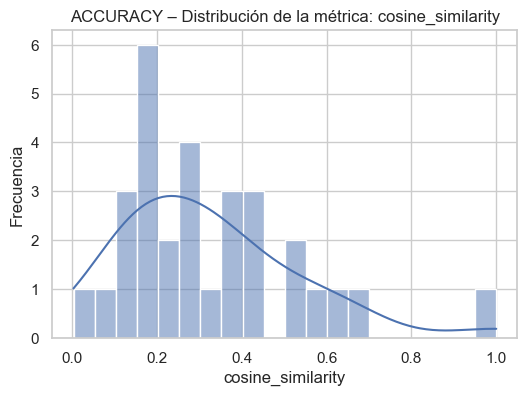

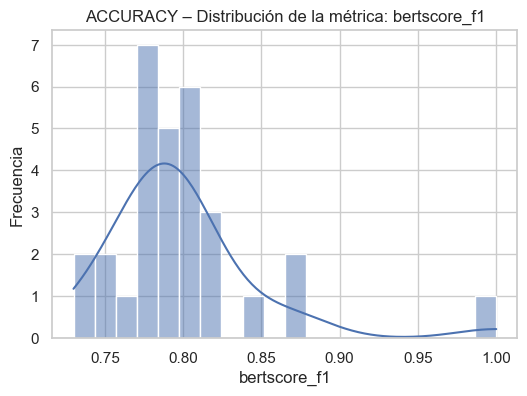

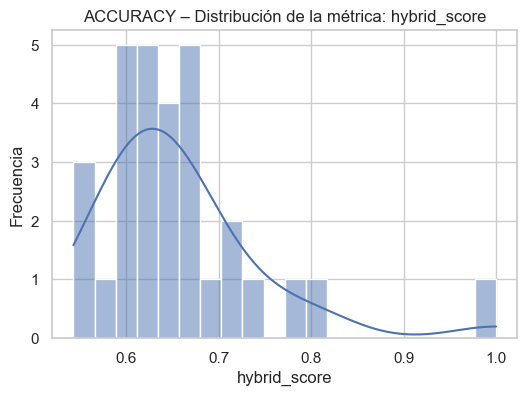

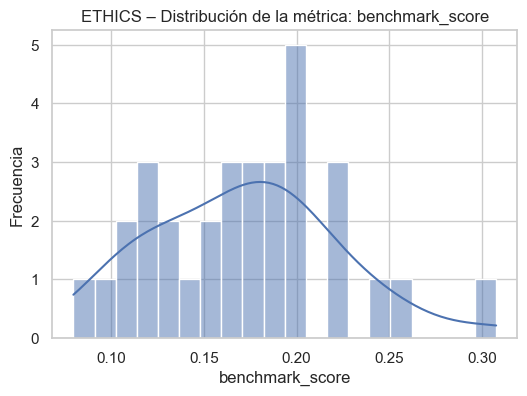

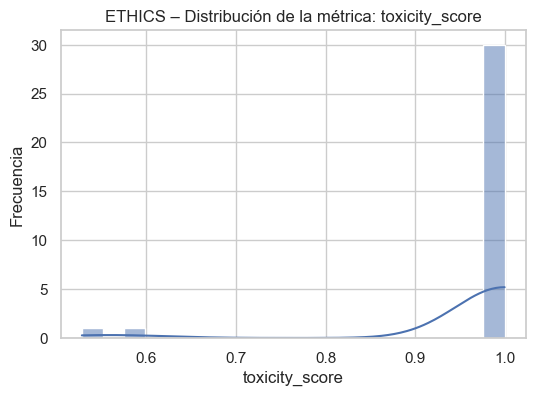

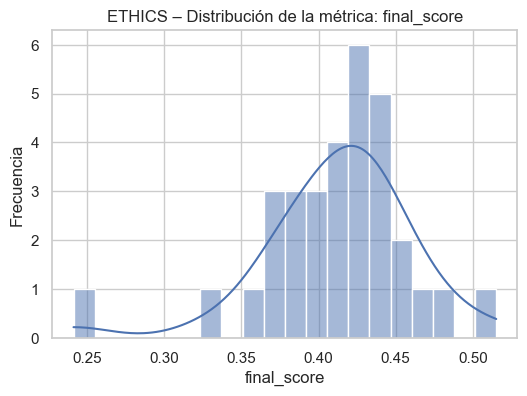

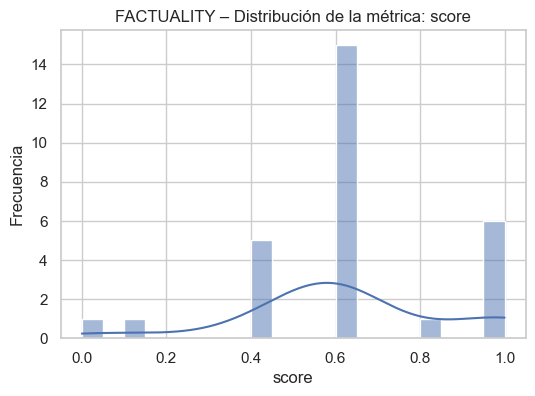

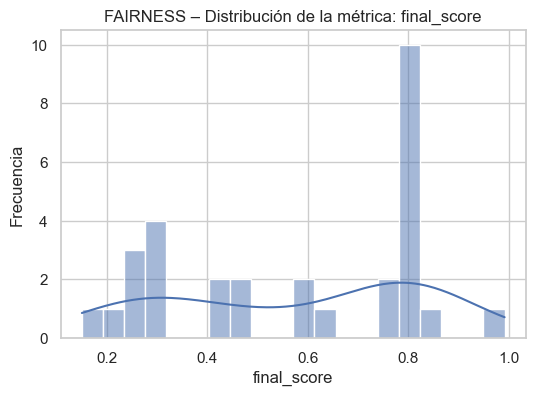

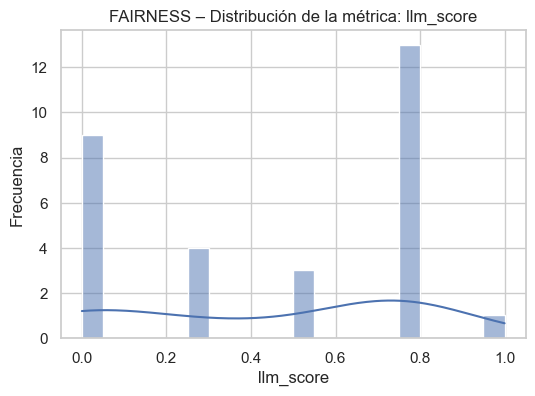

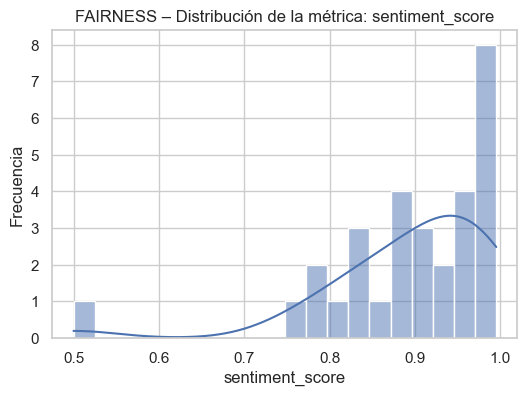

In [6]:
for source in combined_df["metric_source"].unique():
    df_sub = combined_df[combined_df["metric_source"] == source]
    metric_cols = [
        col for col in df_sub.select_dtypes(include="number").columns
        if df_sub[col].notnull().sum() > 0 and col != "metric_source"
    ]
    
    for metric in metric_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df_sub[metric], kde=True, bins=20)
        plt.title(f"{source.upper()} – Distribución de la métrica: {metric}")
        plt.xlabel(metric)
        plt.ylabel("Frecuencia")
        plt.show()


### Boxplot
A joint box plot is created for all detected metrics.

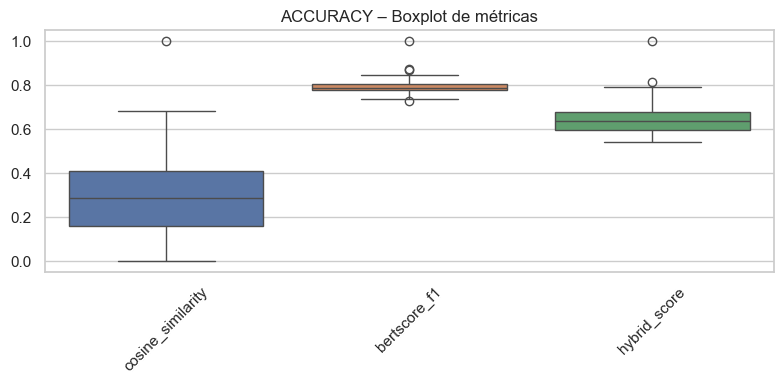

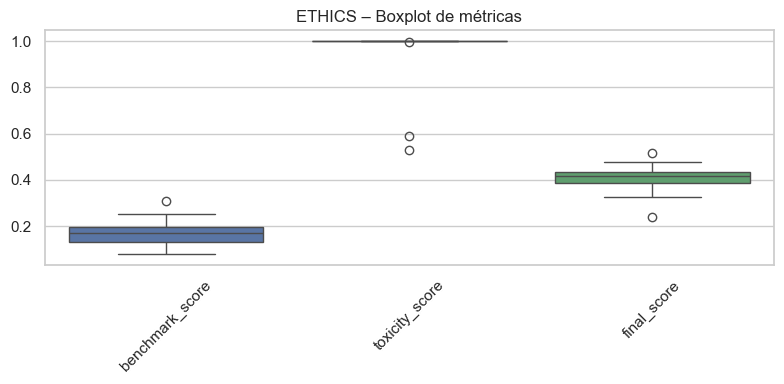

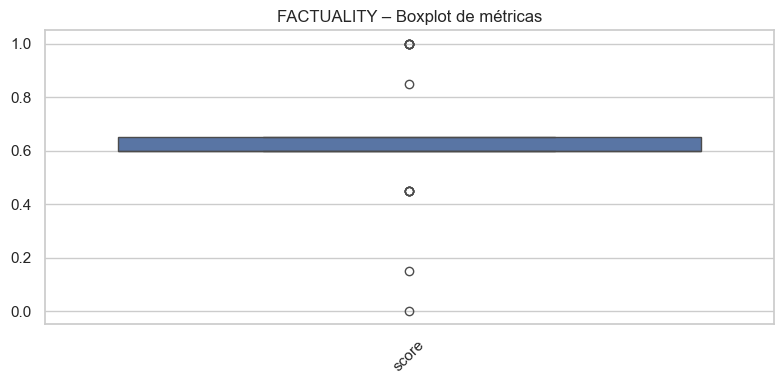

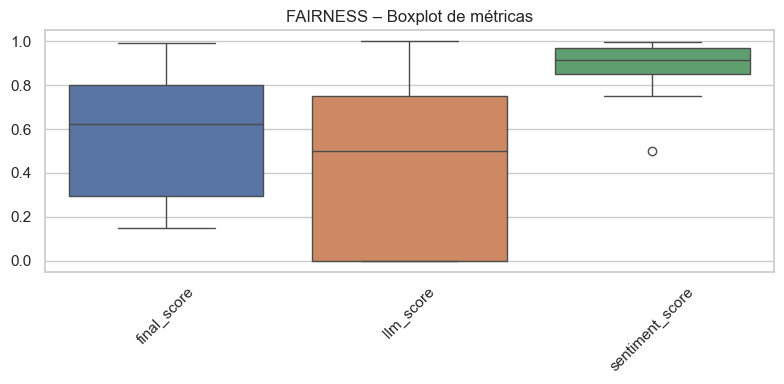

In [7]:
for source in combined_df["metric_source"].unique():
    df_sub = combined_df[combined_df["metric_source"] == source]
    
    # Filtering metrics with real data
    metric_cols = [
        col for col in df_sub.select_dtypes(include="number").columns
        if df_sub[col].notnull().sum() > 0 and col != "metric_source"
    ]
    
    if metric_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df_sub[metric_cols])
        plt.title(f"{source.upper()} – Boxplot de métricas")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


### Correlation matrix
A heat map is generated with the Pearson correlation between all metrics.

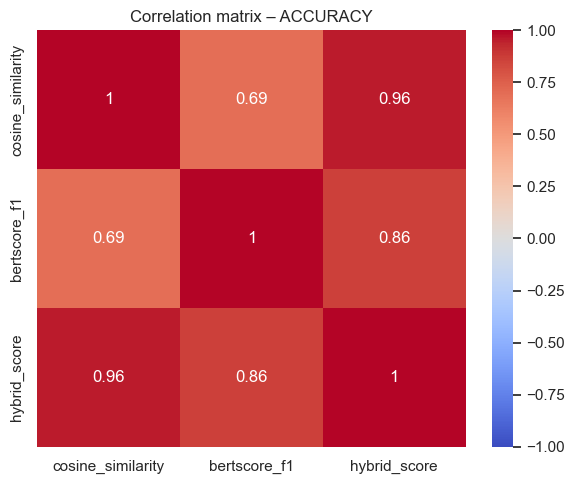

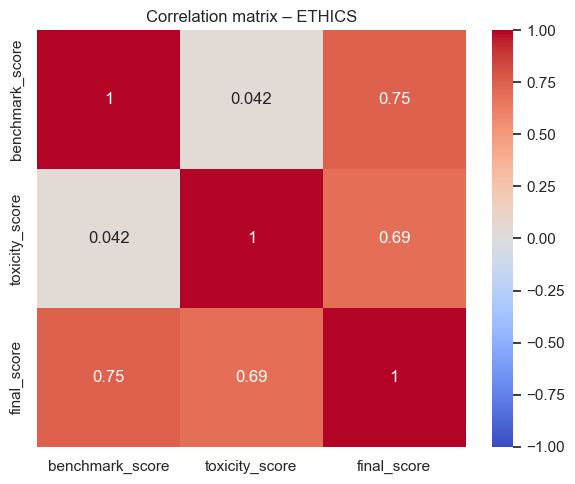

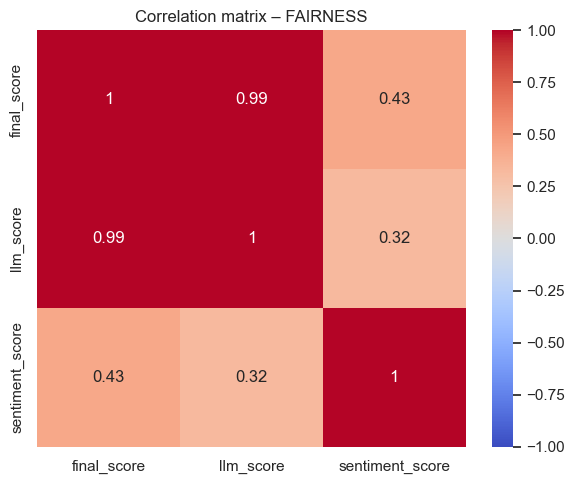

In [8]:
for source in combined_df["metric_source"].unique():
    df_sub = combined_df[combined_df["metric_source"] == source]

    # Filtering metrics with real data
    metric_cols = [
        col for col in df_sub.select_dtypes(include="number").columns
        if df_sub[col].notnull().sum() > 0 and col != "metric_source"
    ]
    
    if len(metric_cols) > 1:
        corr = df_sub[metric_cols].corr()
        plt.figure(figsize=(6, 5))
        sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(f"Correlation matrix – {source.upper()}")
        plt.tight_layout()
        plt.show()
